<a href="https://colab.research.google.com/github/LongNguyen1984/TimeSeriesWithPython/blob/main/YourFirstGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [5]:
img_rows = 28
img_cols = 28
channels = 1

# input image dimensions
img_shape = (img_rows, img_cols, channels)
# Size of the noise vector 
z_dim = 100

#Generator

In [6]:
def build_generator(img_shape, z_dim):
  model = Sequential()
  # Fully connected layer
  model.add(Dense(128, input_dim=z_dim))
  # leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))
  # Output layer with tanh activation
  model.add(Dense(28*28*1, activation='tanh'))
  # Reshape the Generator output to image dimensions
  model.add(Reshape(img_shape))

  return model

# Discrimnator

In [7]:
def build_discriminator(img_shape):
  model = Sequential()
  # Flatten the input image
  model.add(Flatten(input_shape=img_shape))
  # Fully connected layer
  model.add(LeakyReLU(alpha=0.01))
  # Output layer with sigmoid activation
  model.add(Dense(1, activation='sigmoid'))

  return model


# Build the Model

In [8]:
def build_gan(generator, discriminator):
  model = Sequential()
  # Combined Gen. and Disc.
  model.add(generator)
  model.add(discriminator)

  return model

In [9]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])
# Build the Generator
generator = build_generator(img_shape, z_dim)

# Keep discriminator's parameters constant for generator training
discriminator.trainable = False

# Build and compile GAN model with fixed discriminator to train the generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

# Training

In [10]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
  # Load the MNIS dataset
  (X_train, _),(_,_) = mnist.load_data()

  # Rescale [0, 255] grayscale pixel values to [-1, 1]
  X_train = X_train/127.5 - 1.0
  X_train = np.expand_dims(X_train, axis=3)

  # Labels for real images: all ones
  real = np.ones((batch_size,1))

  # Labels for fake images: all zeros
  fake = np.zeros((batch_size,1))

  for iteration in range(iterations):
    #-------------------------------
    # Train the Discriminator
    #-------------------------------

    # Get a random batch of real images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # Geneator a batch of fake images
    z = np.random.normal(0, 1, (batch_size,100))
    gen_imgs = generator.predict(z)

   # Train Discriminator
    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
    # ---------------------
    #  Train the Generator
    # ---------------------

    # Generate a batch of fake images
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # Train Generator
    g_loss = gan.train_on_batch(z, real)

    if (iteration + 1) % sample_interval == 0:

      # Save losses and accuracies so they can be plotted after training
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration + 1)

      # Output training progress
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
        (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

      # Output a sample of generated image
      sample_images(generator)

In [11]:
a = []
a.append(1)
a

[1]

In [12]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
  # Sample random noise
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

  # Generate images from random noise
  gen_imgs = generator.predict(z)

  # Rescale image pixel values to [0, 1]
  gen_imgs = 0.5*gen_imgs + 0.5

  # Set image grid
  fig, axs = plt.subplots(image_grid_rows,
                          image_grid_columns,
                          figsize=(4,4),
                          sharey=True,
                          sharex=True)
  
  cnt = 0
  for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

Train the GAN and Inspect Output

11501568/11490434 [==============================] - 0s 0us/step
1000 [D loss: 0.730276, acc.: 54.69%] [G loss: 0.802972]
2000 [D loss: 0.522208, acc.: 81.25%] [G loss: 1.262977]
3000 [D loss: 0.202222, acc.: 92.19%] [G loss: 3.196866]
4000 [D loss: 0.091240, acc.: 100.00%] [G loss: 3.442297]
5000 [D loss: 0.167694, acc.: 96.88%] [G loss: 2.732242]


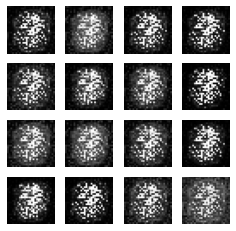

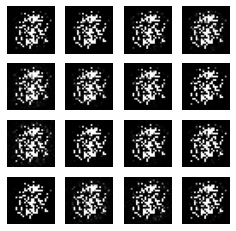

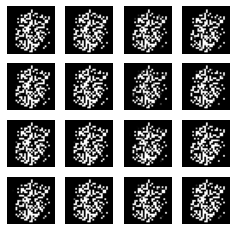

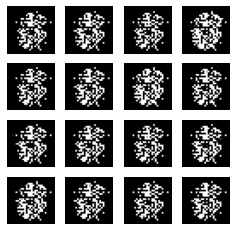

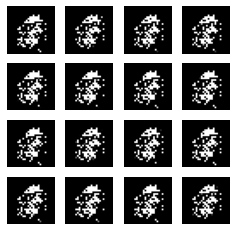

In [13]:
# Set hyperparameters
iterations = 5000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

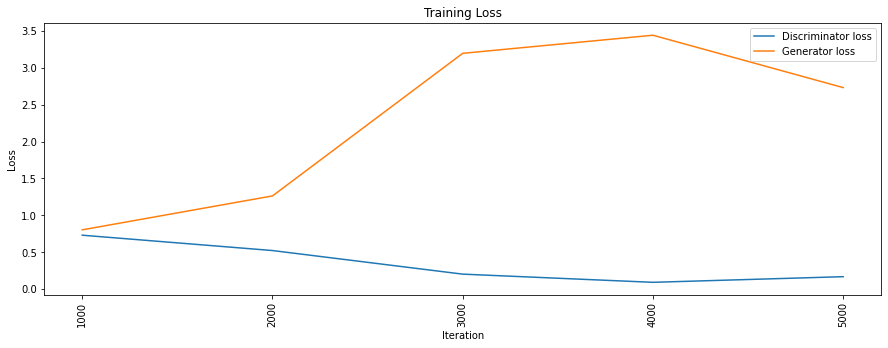

In [16]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

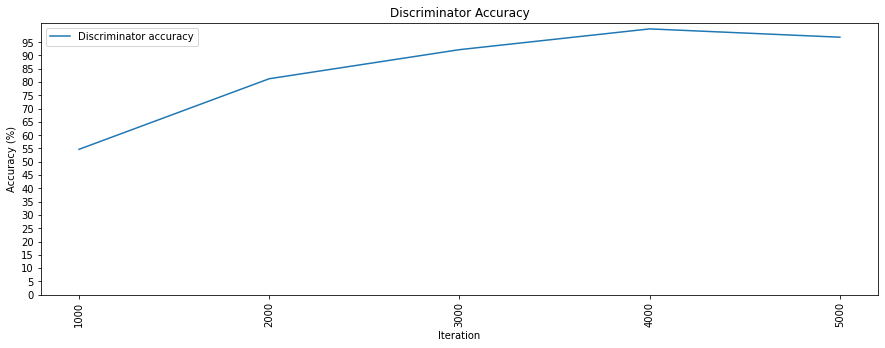

In [15]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

### Move to the folder to download and unzipped data

In [2]:
import os

path = 'drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata'

In [32]:
cd drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata

/content/drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata


In [6]:
!pwd

/content/drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata


### Download Data and Unziped

In [7]:
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/monet2photo.zip
!upzip monet2photo.zip

--2021-08-25 02:48:30--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/monet2photo.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 305231073 (291M) [application/zip]
Saving to: ‘monet2photo.zip’

monet2photo.zip     100%[===================>] 291.09M  3.21MB/s    in 75s     

2021-08-25 02:49:45 (3.86 MB/s) - ‘monet2photo.zip’ saved [305231073/305231073]

/bin/bash: upzip: command not found


In [ ]:
!unzip monet2photo.zip

In [59]:
cd GANdata/

/content/drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata


In [58]:
rm -r drive

In [8]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-fqyd4r3q
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-fqyd4r3q
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=293a04bf140efc90fd317313ead48a5937f45f6e75b7f0ccaf068efd780c85a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-1mfdfqlw/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [73]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import Input, Model
from keras.layers import Conv2D, BatchNormalization, Activation, Add, Conv2DTranspose, ZeroPadding2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras_contrib.layers import InstanceNormalization
from skimage.transform import resize
from matplotlib.pyplot import imread

In [93]:
import time
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import Input, Model
from keras.callbacks import TensorBoard
from keras.layers import Conv2D, BatchNormalization, Activation, Add, Conv2DTranspose, ZeroPadding2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from imageio import imread
from skimage.transform import resize

## Create Generator

In [11]:
input_shape = (128, 128, 3)
residual_blocks = 6

Create a input layer

In [94]:
input_layer = Input(shape=input_shape)

Add first convolution block

In [95]:
x = Conv2D(filters=32, kernel_size=7, strides=1, padding="same")(input_layer)
x = InstanceNormalization(axis=1)(x)
x = Activation("relu")(x)

Add second convolution block

In [96]:
x = Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
x = InstanceNormalization(axis=1)(x)
x = Activation("relu")(x)

Add third convolution block

In [97]:
x = Conv2D(filters=128, kernel_size=3, strides=2, padding="same")(x)
x = InstanceNormalization(axis=1)(x)
x = Activation("relu")(x)

In [12]:
def residual_block(x):
  """
  Residual block
  """
  res = Conv2D(filters=128, kernel_size=3, strides=1, padding="same")(x)
  res = BatchNormalization(axis=3, momentum=0.9, epsilon=1e-5)(res)
  res = Activation('relu')(res)
  res = Conv2D(filters=128, kernel_size=3, strides=1, padding="same")(res)
  res = BatchNormalization(axis=3, momentum=0.9, epsilon=1e-5)(res)
  return Add()([res, x])

Add six residual blocks

In [98]:
for _ in range(residual_blocks):
  x = residual_block(x)

Upsampling block

In [99]:
x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
x = InstanceNormalization(axis=1)(x)
x = Activation("relu")(x)

In [100]:
def build_generator():
  """
  Create a generator network using the hyperparameter values defined below
  """
  input_shape = (128, 128, 3)
  residual_blocks = 6
  input_layer = Input(shape=input_shape)
  # First Convolution block
  x = Conv2D(filters=32, kernel_size=7, strides=1, padding="same")(input_layer)
  x = InstanceNormalization(axis=1)(x)
  x = Activation("relu")(x)
  # 2nd Convolution block
  x = Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
  x = InstanceNormalization(axis=1)(x)
  x = Activation("relu")(x)
  # 3rd Convolution block
  x = Conv2D(filters=128, kernel_size=3, strides=2, padding="same")(x)
  x = InstanceNormalization(axis=1)(x)
  x = Activation("relu")(x)
  # Residual blocks
  for _ in range(residual_blocks):
    x = residual_block(x)
  # Upsampling blocks
  # 1st Upsampling block
  x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
  x = InstanceNormalization(axis=1)(x)
  x = Activation("relu")(x)
  # 2nd Upsampling block
  x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
  x = InstanceNormalization(axis=1)(x)
  x = Activation("relu")(x)
  # Last Convolution layer
  x = Conv2D(filters=3, kernel_size=7, strides=1, padding="same")(x)
  output = Activation('tanh')(x)
  model = Model(inputs=[input_layer], outputs=[output])
  return model

## Create Discreminator

In [20]:
input_shape = (128, 128, 3)
hidden_layers = 3

In [21]:
input_layer = Input(shape=input_shape)

This layer will add padding to the input tensor on both the x and y axes.

In [22]:
x = ZeroPadding2D(padding=(1, 1))(input_layer)

In [23]:
x = Conv2D(filters=64, kernel_size=4, strides=2, padding="valid")(x)
x = LeakyReLU(alpha=0.2)(x)

In [24]:
x = ZeroPadding2D(padding=(1, 1))(x)

In [25]:
for i in range(1, hidden_layers + 1):
  x = Conv2D(filters=2 ** i * 64, kernel_size=4, strides=2, padding="valid")(x)
  x = InstanceNormalization(axis=1)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = ZeroPadding2D(padding=(1, 1))(x)

In [26]:
output = Conv2D(filters=1, kernel_size=4, strides=1, activation="sigmoid")(x)

In [27]:
model = Model(inputs=[input_layer], outputs=[output])

In [14]:
def build_discriminator():
  """
  Create a discriminator network using the hyperparameter values defined below
  """
  input_shape = (128, 128, 3)
  hidden_layers = 3
  input_layer = Input(shape=input_shape)
  x = ZeroPadding2D(padding=(1, 1))(input_layer)
  # 1st Convolutional block
  x = Conv2D(filters=64, kernel_size=4, strides=2, padding="valid")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = ZeroPadding2D(padding=(1, 1))(x)
  # 3 Hidden Convolution blocks
  for i in range(1, hidden_layers + 1):
    x = Conv2D(filters=2 ** i * 64, kernel_size=4, strides=2, padding="valid")(x)
    x = InstanceNormalization(axis=1)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
  # Last Convolution layer
  output = Conv2D(filters=1, kernel_size=4, strides=1, activation="sigmoid")(x)
  model = Model(inputs=[input_layer], outputs=[output])
  return model

## Training the CycleGAN

In [67]:
pwd

'/content/drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata'

In [63]:
#data_dir = "drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata/monet2photo"
data_dir = "monet2photo"

In [5]:
batch_size = 1
epochs = 5

Loading Dataset

In [131]:
imagesA = glob(data_dir + '/testA/*.*')
imagesB = glob(data_dir + '/testB/*.*')

In [130]:
imagesA[1]

'monet2photo/testA/01230.jpg'

In [134]:
allImagesA = []
allImagesB = []
# Iterate over the lists
for index, filename in enumerate(imagesA):
  # Load images
  #print(filename)
  imgA = imread(filename)
  imgB = imread(imagesB[index]) #format = 'RGB'
  # Resize images
  imgA = resize(imgA, (128, 128))
  imgB = resize(imgB, (128, 128))
  # Randomly horizontally flip images
  if np.random.random() > 0.5:
    imgA = np.fliplr(imgA)
    imgB = np.fliplr(imgB)
  allImagesA.append(imgA)
  allImagesB.append(imgB)

In [124]:
pwd

'/content/drive/Shareddrives/AIOT_LAB_DOCS/Data/GANdata'

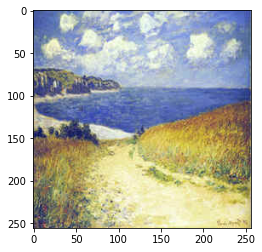

In [127]:
A = imread('monet2photo/testA/00010.jpg')
plt.figure()
plt.imshow(A)

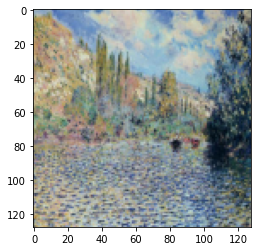

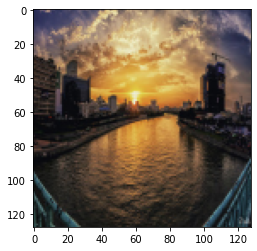

In [135]:
plt.figure()
plt.imshow(allImagesA[0])
plt.figure()
plt.imshow(allImagesB[0])

In [45]:
# Normalize images
allImagesA = np.array(allImagesA) / 127.5 - 1.
allImagesB = np.array(allImagesB) / 127.5 - 1.

In [136]:
def load_images(data_dir):
  imagesA = glob(data_dir + '/testA/*.*')
  imagesB = glob(data_dir + '/testB/*.*')
  allImagesA = []
  allImagesB = []
  for index, filename in enumerate(imagesA):
    # Load images
    imgA = imread(filename )#format='RGB'
    imgB = imread(imagesB[index] )#format='RGB'
    # Resize images
    imgA = resize(imgA, (128, 128))
    imgB = resize(imgB, (128, 128))
    # Randomly horizontally flip images
    if np.random.random() > 0.5:
      imgA = np.fliplr(imgA)
      imgB = np.fliplr(imgB)
    allImagesA.append(imgA)
    allImagesB.append(imgB)
  # Normalize images
  allImagesA = np.array(allImagesA) / 127.5 - 1.
  allImagesB = np.array(allImagesB) / 127.5 - 1.
  return allImagesA, allImagesB

Building and Compile the networks

In [105]:
# Define the common optimizer
common_optimizer = Adam(0.002, 0.5)

In [106]:
discriminatorA = build_discriminator()
discriminatorB = build_discriminator()

In [107]:
discriminatorA.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])
discriminatorB.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

In [108]:
generatorAToB = build_generator()
generatorBToA = build_generator()

Create and Compiling an adversarial network

In [109]:
inputA = Input(shape=(128, 128, 3))
inputB = Input(shape=(128, 128, 3))

In [110]:
generatedB = generatorAToB(inputA)
generatedA = generatorBToA(inputB)

In [111]:
reconstructedA = generatorBToA(generatedB)
reconstructedB = generatorAToB(generatedA)

Using genearator to make fake image

In [112]:
generatedAId = generatorBToA(inputA)
generatedBId = generatorAToB(inputB)

In [113]:
discriminatorA.trainable = False
discriminatorB.trainable = False

In [114]:
probsA = discriminatorA(generatedA)
probsB = discriminatorB(generatedB)

In [26]:
adversarial_model = Model(inputs=[inputA, inputB],outputs=[probsA, probsB, reconstructedA, reconstructedB, generatedAId, generatedBId]) 

In [115]:
adversarial_model.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'],
loss_weights=[1, 1, 10.0, 10.0, 1.0, 1.0],
optimizer=common_optimizer)

In [116]:
from keras.callbacks import TensorBoard
import time
tensorboard = TensorBoard(log_dir="logs/{}".format(time.time()), write_images=True, write_grads=True, write_graph=True)
tensorboard.set_model(generatorAToB)
tensorboard.set_model(generatorBToA)
tensorboard.set_model(discriminatorA)
tensorboard.set_model(discriminatorB)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [117]:
real_labels = np.ones((batch_size, 7, 7, 1))
fake_labels = np.zeros((batch_size, 7, 7, 1))

###Start Training

In [137]:
imagesA, imagesB = load_images(data_dir=data_dir)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


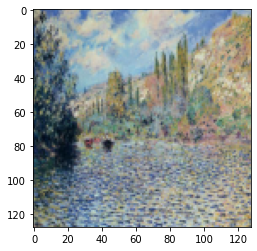

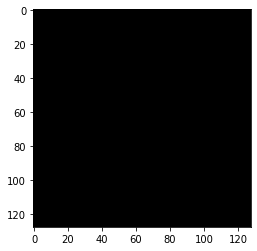

In [142]:
plt.figure()
plt.imshow((imagesA[0]+1)*127.5)
plt.figure()
plt.imshow(imagesB[1])

In [143]:
def load_test_batch(data_dir, batch_size):
    imagesA = glob(data_dir + '/testA/*.*')
    imagesB = glob(data_dir + '/testB/*.*')

    imagesA = np.random.choice(imagesA, batch_size)
    imagesB = np.random.choice(imagesB, batch_size)

    allA = []
    allB = []

    for i in range(len(imagesA)):
        # Load images and resize images
        imgA = resize(imread(imagesA[i]).astype(np.float32), (128, 128))
        imgB = resize(imread(imagesB[i]).astype(np.float32), (128, 128))

        allA.append(imgA)
        allB.append(imgB)

    return np.array(allA) / 127.5 - 1.0, np.array(allB) / 127.5 - 1.0


In [51]:
def write_log(callback, name, loss, batch_no):
    """
    Write training summary to TensorBoard
    """
    #writer = tf.summary.create_file_writer("/tmp/mylogs")
    #with writer.as_default():
    summary = tf.summary.scalar(name, loss, step=batch_no)
    callback.on_epoch_end(batch_no, summary)
    #callback.writer.flush()

In [ ]:
epochs = 100
for epoch in range(epochs):
  print("Epoch:{}".format(epoch))
  dis_losses = []
  gen_losses = []
  
  num_batches = int(min(imagesA.shape[0], imagesB.shape[0])/ batch_size)
  print("Number of batches:{}".format(num_batches))
  
  for index in range(num_batches):
    print("Batch:{}".format(index))
    # Sample images
    batchA = imagesA[index * batch_size:(index + 1) * batch_size]
    batchB = imagesB[index * batch_size:(index + 1) * batch_size] 
    # Translate images to opposite domain
    generatedB = generatorAToB.predict(batchA)
    generatedA = generatorBToA.predict(batchB)
    # Train the discriminator A on real and fake images
    dALoss1 = discriminatorA.train_on_batch(batchA, real_labels)
    dALoss2 = discriminatorB.train_on_batch(generatedA, fake_labels)
    # Train the discriminator B on ral and fake images
    dBLoss1 = discriminatorB.train_on_batch(batchB, real_labels)
    dbLoss2 = discriminatorB.train_on_batch(generatedB, fake_labels)
    # Calculate the total discriminator loss
    d_loss = 0.5 * np.add(0.5 * np.add(dALoss1, dALoss2), 0.5 * np.add(dBLoss1, dbLoss2))
    #print("d_loss:{}".format(d_loss))
    """
    Train the generator networks
    """
    
    g_loss = adversarial_model.train_on_batch([batchA, batchB], [real_labels, real_labels, batchA, batchB, batchA, batchB])
    
    #print("g_loss:{}".format(g_loss))

    dis_losses.append(d_loss)
    gen_losses.append(g_loss)
  """
  Save losses to Tensorboard after each epoch
  """
  write_log(tensorboard, 'discriminator_loss', np.mean(dis_losses), epoch)
  write_log(tensorboard, 'generator_loss', np.mean(gen_losses), epoch)
  
  if epoch % 10 == 0:
    # Get a batch of test data
    batchA, batchB = load_test_batch(data_dir=data_dir, batch_size=2)
    # Generate images
    generatedB = generatorAToB.predict(batchA)
    generatedA = generatorBToA.predict(batchB)
    # Get reconstructed images
    reconsA = generatorBToA.predict(generatedB)
    reconsB = generatorAToB.predict(generatedA)
    # Save original, generated and reconstructed images
    for i in range(len(generatedA)):
      save_images(originalA=batchA[i], generatedB=generatedB[i], recosntructedA=reconsA[i],
        originalB=batchB[i], generatedA=generatedA[i], reconstructedB=reconsB[i],
        path="results/gen_{}_{}".format(epoch, i))

# Save models
generatorAToB.save_weights("generatorAToB.h5")
generatorBToA.save_weights("generatorBToA.h5")
discriminatorA.save_weights("discriminatorA.h5")
discriminatorB.save_weights("discriminatorB.h5") 




Epoch:0
Number of batches:121
Batch:0
Batch:1
Batch:2
Batch:3
Batch:4
Batch:5
Batch:6
Batch:7
Batch:8
Batch:9
Batch:10
Batch:11
Batch:12
Batch:13
Batch:14
Batch:15
Batch:16
Batch:17
Batch:18
Batch:19
Batch:20
Batch:21
Batch:22
Batch:23
Batch:24
Batch:25
Batch:26
Batch:27
Batch:28
Batch:29
Batch:30
Batch:31
Batch:32
Batch:33
Batch:34
Batch:35
Batch:36
Batch:37
Batch:38
Batch:39
Batch:40
Batch:41
Batch:42
Batch:43
Batch:44
Batch:45
Batch:46
Batch:47
Batch:48
Batch:49
Batch:50
Batch:51
Batch:52
Batch:53
Batch:54
Batch:55
Batch:56
Batch:57
Batch:58
Batch:59
Batch:60
Batch:61
Batch:62
Batch:63
Batch:64
Batch:65
Batch:66
Batch:67
Batch:68
Batch:69
Batch:70
Batch:71
Batch:72
Batch:73
Batch:74
Batch:75
Batch:76
Batch:77
Batch:78
Batch:79
Batch:80
Batch:81
Batch:82
Batch:83
Batch:84
Batch:85
Batch:86
Batch:87
Batch:88
Batch:89
Batch:90
Batch:91
Batch:92
Batch:93
Batch:94
Batch:95
Batch:96
Batch:97
Batch:98
Batch:99
Batch:100
Batch:101
Batch:102
Batch:103
Batch:104
Batch:105
Batch:106
Batch:107


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch:1
Number of batches:121
Batch:0
Batch:1
Batch:2
Batch:3
Batch:4
Batch:5
Batch:6
Batch:7
Batch:8
Batch:9
Batch:10
Batch:11
Batch:12
Batch:13
Batch:14
Batch:15
Batch:16
Batch:17
Batch:18
Batch:19
Batch:20
Batch:21
Batch:22
Batch:23
Batch:24
Batch:25
Batch:26
Batch:27
Batch:28
Batch:29
Batch:30
Batch:31
Batch:32
Batch:33
Batch:34
Batch:35
Batch:36
Batch:37
Batch:38
Batch:39
Batch:40
Batch:41
Batch:42
Batch:43
Batch:44
Batch:45
Batch:46
Batch:47
Batch:48
Batch:49
Batch:50
Batch:51
Batch:52
Batch:53
Batch:54
Batch:55
Batch:56
Batch:57
Batch:58
Batch:59
Batch:60
Batch:61
Batch:62
Batch:63
Batch:64
Batch:65
Batch:66
Batch:67
Batch:68
Batch:69
Batch:70
Batch:71
Batch:72
Batch:73
Batch:74
Batch:75
Batch:76
Batch:77
Batch:78
Batch:79
Batch:80
Batch:81
Batch:82
Batch:83
Batch:84
Batch:85
Batch:86
Batch:87
Batch:88
Batch:89
Batch:90
Batch:91
Batch:92
Batch:93
Batch:94
Batch:95
Batch:96
Batch:97
Batch:98
Batch:99
Batch:100
Batch:101
Batch:102
Batch:103
Batch:104
Batch:105
Batch:106
Batch:107


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch:11
Number of batches:121
Batch:0
Batch:1
Batch:2
Batch:3
Batch:4
Batch:5
Batch:6
Batch:7
Batch:8
Batch:9
Batch:10
Batch:11
Batch:12
Batch:13
Batch:14
Batch:15
Batch:16
Batch:17
Batch:18
Batch:19
Batch:20
Batch:21
Batch:22
Batch:23
Batch:24
Batch:25
Batch:26
Batch:27
Batch:28
Batch:29
Batch:30
Batch:31
Batch:32
Batch:33
Batch:34
Batch:35
Batch:36
Batch:37
Batch:38
Batch:39
Batch:40
Batch:41
Batch:42
Batch:43
Batch:44
Batch:45
Batch:46
Batch:47
Batch:48
Batch:49
Batch:50
Batch:51
Batch:52
Batch:53
Batch:54
Batch:55
Batch:56
Batch:57
Batch:58
Batch:59
Batch:60
Batch:61
Batch:62
Batch:63
Batch:64
Batch:65
Batch:66
Batch:67
Batch:68
Batch:69
Batch:70
Batch:71
Batch:72
Batch:73
Batch:74
Batch:75
Batch:76
Batch:77
Batch:78
Batch:79
Batch:80
Batch:81
Batch:82
Batch:83
Batch:84
Batch:85
Batch:86
Batch:87
Batch:88
Batch:89
Batch:90
Batch:91
Batch:92
Batch:93
Batch:94
Batch:95
Batch:96
Batch:97
Batch:98
Batch:99
Batch:100
Batch:101
Batch:102
Batch:103
Batch:104
Batch:105
Batch:106
Batch:107

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch:21
Number of batches:121
Batch:0
Batch:1
Batch:2
Batch:3
Batch:4
Batch:5
Batch:6
Batch:7
Batch:8
Batch:9
Batch:10
Batch:11
Batch:12
Batch:13
Batch:14
Batch:15
Batch:16
Batch:17
Batch:18
Batch:19
Batch:20
Batch:21
Batch:22
Batch:23
Batch:24
Batch:25
Batch:26
Batch:27
Batch:28
Batch:29
Batch:30
Batch:31
Batch:32
Batch:33
Batch:34
Batch:35
Batch:36
Batch:37
Batch:38
Batch:39
Batch:40
Batch:41
Batch:42
Batch:43
Batch:44
Batch:45
Batch:46
Batch:47
Batch:48
Batch:49
Batch:50
Batch:51
Batch:52
Batch:53
Batch:54
Batch:55
Batch:56
Batch:57
Batch:58
Batch:59
Batch:60
Batch:61
Batch:62
Batch:63
Batch:64
Batch:65
Batch:66
Batch:67
Batch:68
Batch:69
Batch:70
Batch:71
Batch:72
Batch:73
Batch:74
Batch:75
Batch:76
Batch:77
Batch:78
Batch:79
Batch:80
Batch:81
Batch:82
Batch:83
Batch:84
Batch:85
Batch:86
Batch:87
Batch:88
Batch:89
Batch:90
Batch:91
Batch:92
Batch:93
Batch:94
Batch:95
Batch:96
Batch:97
Batch:98
Batch:99
Batch:100
Batch:101
Batch:102
Batch:103
Batch:104
Batch:105
Batch:106
Batch:107

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch:31
Number of batches:121
Batch:0
Batch:1
Batch:2
Batch:3
Batch:4
Batch:5
Batch:6
Batch:7
Batch:8
Batch:9
Batch:10
Batch:11
Batch:12
Batch:13
Batch:14
Batch:15
Batch:16
Batch:17
Batch:18
Batch:19
Batch:20
Batch:21
Batch:22
Batch:23
Batch:24
Batch:25
Batch:26
Batch:27
Batch:28
Batch:29
Batch:30
Batch:31
Batch:32
Batch:33
Batch:34
Batch:35
Batch:36
Batch:37
Batch:38
Batch:39
Batch:40
Batch:41
Batch:42
Batch:43
Batch:44
Batch:45
Batch:46
Batch:47
Batch:48
Batch:49
Batch:50
Batch:51
Batch:52
Batch:53
Batch:54
Batch:55
Batch:56
Batch:57
Batch:58
Batch:59
Batch:60
Batch:61
Batch:62
Batch:63
Batch:64
Batch:65
Batch:66
Batch:67
Batch:68
Batch:69
Batch:70
Batch:71
Batch:72
Batch:73
Batch:74
Batch:75
Batch:76
Batch:77
Batch:78
Batch:79
Batch:80
Batch:81
Batch:82
Batch:83
Batch:84
Batch:85
Batch:86
Batch:87
Batch:88
Batch:89
Batch:90
Batch:91
Batch:92
Batch:93
Batch:94
Batch:95
Batch:96
Batch:97
Batch:98
Batch:99
Batch:100
Batch:101
Batch:102
Batch:103
Batch:104
Batch:105
Batch:106
Batch:107

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch:41
Number of batches:121
Batch:0
Batch:1
Batch:2
Batch:3
Batch:4
Batch:5
Batch:6
Batch:7
Batch:8
Batch:9
Batch:10
Batch:11
Batch:12
Batch:13
Batch:14
Batch:15
Batch:16
Batch:17
Batch:18
Batch:19
Batch:20
Batch:21
Batch:22
Batch:23
Batch:24
Batch:25
Batch:26
Batch:27
Batch:28
Batch:29
Batch:30
Batch:31
Batch:32
Batch:33
Batch:34
Batch:35
Batch:36
Batch:37
Batch:38
Batch:39
Batch:40
Batch:41
Batch:42
Batch:43
Batch:44
Batch:45
Batch:46
Batch:47
Batch:48
Batch:49
Batch:50
Batch:51
Batch:52
Batch:53
Batch:54
Batch:55
Batch:56
Batch:57
Batch:58
Batch:59
Batch:60
Batch:61
Batch:62
Batch:63
Batch:64
Batch:65
Batch:66
Batch:67
Batch:68
Batch:69
Batch:70
Batch:71
Batch:72
Batch:73
Batch:74
Batch:75
Batch:76
Batch:77
Batch:78
Batch:79
Batch:80
Batch:81
Batch:82
Batch:83
Batch:84
Batch:85
Batch:86
Batch:87
Batch:88
Batch:89
Batch:90
Batch:91
Batch:92
Batch:93
Batch:94
Batch:95
Batch:96
Batch:97
Batch:98
Batch:99
Batch:100
Batch:101
Batch:102
Batch:103
Batch:104
Batch:105
Batch:106
Batch:107

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch:51
Number of batches:121
Batch:0
Batch:1
Batch:2
Batch:3
Batch:4
Batch:5
Batch:6
Batch:7
Batch:8
Batch:9
Batch:10
Batch:11
Batch:12
Batch:13
Batch:14
Batch:15
Batch:16
Batch:17
Batch:18
Batch:19
Batch:20
Batch:21
Batch:22
Batch:23
Batch:24
Batch:25
Batch:26
Batch:27
Batch:28
Batch:29
Batch:30
Batch:31
Batch:32
Batch:33
Batch:34
Batch:35
Batch:36
Batch:37
Batch:38
Batch:39
Batch:40
Batch:41
Batch:42
Batch:43
Batch:44
Batch:45
Batch:46
Batch:47
Batch:48
Batch:49
Batch:50
Batch:51
Batch:52
Batch:53
Batch:54
Batch:55
Batch:56
Batch:57
Batch:58
Batch:59
Batch:60
Batch:61
Batch:62
Batch:63
Batch:64
Batch:65
Batch:66
Batch:67
Batch:68
Batch:69
Batch:70
Batch:71
Batch:72
Batch:73
Batch:74
Batch:75
Batch:76
Batch:77
Batch:78
Batch:79
Batch:80
Batch:81
Batch:82
Batch:83
Batch:84
Batch:85
Batch:86
Batch:87
Batch:88
Batch:89
Batch:90
Batch:91
Batch:92
Batch:93
Batch:94
Batch:95
Batch:96
Batch:97
Batch:98
Batch:99
Batch:100
Batch:101
Batch:102
Batch:103
Batch:104
Batch:105
Batch:106
Batch:107

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch:61
Number of batches:121
Batch:0
Batch:1
Batch:2
Batch:3
Batch:4
Batch:5
Batch:6
Batch:7
Batch:8
Batch:9
Batch:10
Batch:11
Batch:12
Batch:13
Batch:14
Batch:15
Batch:16
Batch:17
Batch:18
Batch:19
Batch:20
Batch:21
Batch:22
Batch:23
Batch:24
Batch:25
Batch:26
Batch:27
Batch:28
Batch:29
Batch:30
Batch:31
Batch:32
Batch:33
Batch:34
Batch:35
Batch:36
Batch:37
Batch:38
Batch:39
Batch:40
Batch:41
Batch:42
Batch:43
Batch:44
Batch:45
Batch:46
Batch:47
Batch:48
Batch:49
Batch:50
Batch:51
Batch:52
Batch:53
Batch:54
Batch:55
Batch:56
Batch:57
Batch:58
Batch:59
Batch:60
Batch:61
Batch:62
Batch:63
Batch:64
Batch:65
Batch:66
Batch:67
Batch:68
Batch:69
Batch:70
Batch:71
Batch:72
Batch:73
Batch:74
Batch:75
Batch:76
Batch:77
Batch:78
Batch:79
Batch:80
Batch:81
Batch:82
Batch:83
Batch:84
Batch:85
Batch:86
Batch:87
Batch:88
Batch:89
Batch:90
Batch:91
Batch:92
Batch:93
Batch:94
Batch:95
Batch:96
Batch:97
Batch:98
Batch:99
Batch:100
Batch:101
Batch:102
Batch:103
Batch:104
Batch:105
Batch:106
Batch:107

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch:71
Number of batches:121
Batch:0
Batch:1
Batch:2
Batch:3
Batch:4
Batch:5
Batch:6
Batch:7
Batch:8
Batch:9
Batch:10
Batch:11
Batch:12
Batch:13
Batch:14
Batch:15
Batch:16
Batch:17
Batch:18
Batch:19
Batch:20
Batch:21
Batch:22
Batch:23
Batch:24
Batch:25
Batch:26
Batch:27
Batch:28
Batch:29
Batch:30
Batch:31
Batch:32
Batch:33
Batch:34
Batch:35
Batch:36
Batch:37
Batch:38
Batch:39
Batch:40
Batch:41
Batch:42
Batch:43
Batch:44
Batch:45
Batch:46
Batch:47
Batch:48
Batch:49
Batch:50
Batch:51
Batch:52
Batch:53
Batch:54
Batch:55
Batch:56
Batch:57
Batch:58
Batch:59
Batch:60
Batch:61
Batch:62
Batch:63
Batch:64
Batch:65
Batch:66
Batch:67
Batch:68
Batch:69
Batch:70
Batch:71
Batch:72
Batch:73
Batch:74
Batch:75
Batch:76
Batch:77
Batch:78
Batch:79
Batch:80
Batch:81
Batch:82
Batch:83
Batch:84
Batch:85
Batch:86
Batch:87
Batch:88
Batch:89
Batch:90
Batch:91
Batch:92
Batch:93
Batch:94
Batch:95
Batch:96
Batch:97
Batch:98
Batch:99
Batch:100
Batch:101
Batch:102
Batch:103
Batch:104
Batch:105
Batch:106
Batch:107

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch:81
Number of batches:121
Batch:0
Batch:1
Batch:2
Batch:3
Batch:4
Batch:5
Batch:6
Batch:7
Batch:8
Batch:9
Batch:10
Batch:11
Batch:12
Batch:13
Batch:14
Batch:15
Batch:16
Batch:17
Batch:18
Batch:19
Batch:20
Batch:21
Batch:22
Batch:23
Batch:24
Batch:25
Batch:26
Batch:27
Batch:28
Batch:29
Batch:30
Batch:31
Batch:32
Batch:33
Batch:34
Batch:35
Batch:36
Batch:37
Batch:38
Batch:39
Batch:40
Batch:41
Batch:42
Batch:43
Batch:44
Batch:45
Batch:46
Batch:47
Batch:48
Batch:49
Batch:50
Batch:51
Batch:52
Batch:53
Batch:54
Batch:55
Batch:56
Batch:57
Batch:58
Batch:59
Batch:60
Batch:61
Batch:62
Batch:63
Batch:64
Batch:65
Batch:66
Batch:67
Batch:68
Batch:69
Batch:70
Batch:71
Batch:72
Batch:73
Batch:74
Batch:75
Batch:76
Batch:77
Batch:78
Batch:79
Batch:80
Batch:81
Batch:82
Batch:83
Batch:84
Batch:85
Batch:86
Batch:87
Batch:88
Batch:89
Batch:90
Batch:91
Batch:92
Batch:93
Batch:94
Batch:95
Batch:96
Batch:97
Batch:98
Batch:99
Batch:100
Batch:101
Batch:102
Batch:103
Batch:104
Batch:105
Batch:106
Batch:107

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch:91
Number of batches:121
Batch:0
Batch:1
Batch:2
Batch:3
Batch:4
Batch:5
Batch:6
Batch:7
Batch:8
Batch:9
Batch:10
Batch:11
Batch:12
Batch:13
Batch:14
Batch:15
Batch:16
Batch:17
Batch:18
Batch:19
Batch:20
Batch:21
Batch:22
Batch:23
Batch:24
Batch:25
Batch:26
Batch:27
Batch:28
Batch:29
Batch:30
Batch:31
Batch:32
Batch:33
Batch:34
Batch:35
Batch:36
Batch:37
Batch:38
Batch:39
Batch:40
Batch:41
Batch:42
Batch:43
Batch:44
Batch:45
Batch:46
Batch:47
Batch:48
Batch:49
Batch:50
Batch:51
Batch:52
Batch:53
Batch:54
Batch:55
Batch:56
Batch:57
Batch:58
Batch:59
Batch:60
Batch:61
Batch:62
Batch:63
Batch:64
Batch:65
Batch:66
Batch:67
Batch:68
Batch:69
Batch:70
Batch:71
Batch:72
Batch:73
Batch:74
Batch:75
Batch:76
Batch:77
Batch:78
Batch:79
Batch:80
Batch:81
Batch:82
Batch:83
Batch:84
Batch:85
Batch:86
Batch:87
Batch:88
Batch:89
Batch:90
Batch:91
Batch:92
Batch:93
Batch:94
Batch:95
Batch:96
Batch:97
Batch:98
Batch:99
Batch:100
Batch:101
Batch:102
Batch:103
Batch:104
Batch:105
Batch:106
Batch:107

In [85]:
mkdir -p results

In [152]:
len(generatedA)

TypeError: ignored

In [144]:
batchA, batchB = load_test_batch(data_dir=data_dir, batch_size=2)

TypeError: ignored

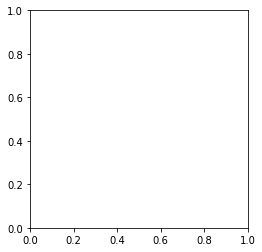

In [151]:
plt.imshow(generatedB[0])

In [1]:
def save_images(originalA, generatedB, recosntructedA, originalB, generatedA, reconstructedB, path):
    """
    Save images
    """
    fig = plt.figure()
    ax = fig.add_subplot(2, 3, 1)
    ax.imshow(originalA)
    ax.axis("off")
    ax.set_title("Original")

    ax = fig.add_subplot(2, 3, 2)
    ax.imshow(generatedB)
    ax.axis("off")
    ax.set_title("Generated")

    ax = fig.add_subplot(2, 3, 3)
    ax.imshow(recosntructedA)
    ax.axis("off")
    ax.set_title("Reconstructed")

    ax = fig.add_subplot(2, 3, 4)
    ax.imshow(originalB)
    ax.axis("off")
    ax.set_title("Original")

    ax = fig.add_subplot(2, 3, 5)
    ax.imshow(generatedA)
    ax.axis("off")
    ax.set_title("Generated")

    ax = fig.add_subplot(2, 3, 6)
    ax.imshow(reconstructedB)
    ax.axis("off")
    ax.set_title("Reconstructed")

    plt.savefig(path)

In [31]:
pwd

'/content'